In [1]:
import pandas as pd
import numpy as np
import itertools
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from helpers.funcs import resample, single_ts_split, timeseries_train_test_split as TSSplit
import matplotlib.pyplot as plt
%matplotlib inline
NB_SEED = 123123

/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  retu

In [2]:
def setindexdatetime(df, index_col):
    df[index_col] = pd.to_datetime(df[index_col])
    df.set_index(index_col, inplace=True)
    df = df.astype(np.float)
    return df

In [3]:
tr = setindexdatetime(pd.read_csv('valids/v_ready_iqr_tr.csv'),'Timestamp')
ts = setindexdatetime(pd.read_csv('valids/v_ready_iqr_ts.csv'),'Timestamp')

In [4]:
tr.index.freq = '15T'

In [5]:
ts = resample(ts)

/home/berkkarahan/Desktop/tupras_isoforest/helpers/funcs.py:39: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  tseries.index[0], pd.tslib.Timestamp), 'Object must have a datetime-like index.'
/home/berkkarahan/Desktop/tupras_isoforest/helpers/funcs.py:73: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  tseries = tseries.resample(short_rate, how='mean').interpolate()
/home/berkkarahan/Desktop/tupras_isoforest/helpers/funcs.py:76: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).ffill()
  tseries = tseries.resample(rate, how='ffill')


In [6]:
x_tr, x_ts, y_tr, y_ts = TSSplit(tr.drop('Target',1),tr.Target, test_size=0.30)

In [7]:
from xgboost import XGBRegressor

In [8]:
reg = XGBRegressor(random_state=NB_SEED)
p = reg.get_params()
p['n_jobs'] = -1
p['reg_lambda'] = 0.3

In [9]:
from helpers.funcs import fit_model_cv

In [10]:
mdls = fit_model_cv(reg,x_tr.values,y_tr.values)

In [11]:
y_pred = np.zeros((y_ts.shape[0],len(mdls)))
for i, m in enumerate(mdls):
    y_pred[:,i]= m.predict(x_ts.values)
y_pred = y_pred.mean(axis=1)

In [12]:
y_pred = pd.Series(data=y_pred, index=y_ts.index)

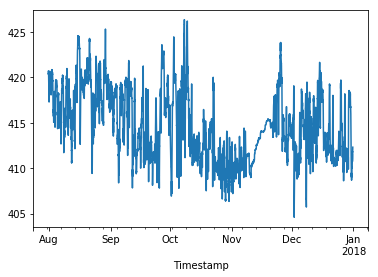

In [13]:
y_pred.plot()

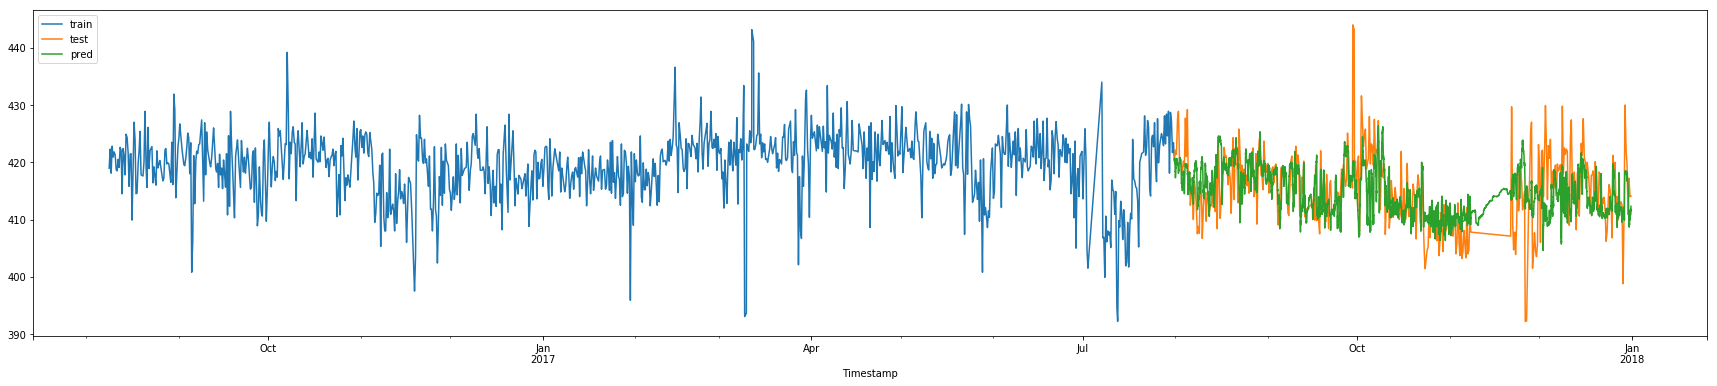

In [14]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [16]:
def print_metric(metrictr, metricts ,mname):
    print(mname +' train: ' + str(metrictr) + ' test: ' + str(metricts))

In [27]:
reg = XGBRegressor(random_state=NB_SEED)
p = reg.get_params()
p['n_jobs'] = -1
p['reg_lambda'] = 0.3

In [28]:
mdls = fit_model_cv(reg,x_tr.values,y_tr.values)
y_pred_val = np.zeros((y_ts.shape[0],len(mdls)))
y_pred_tr = np.zeros((y_tr.shape[0],len(mdls)))
for i, m in enumerate(mdls):
    y_pred_val[:,i]= m.predict(x_ts.values)
    y_pred_tr[:,i] = m.predict(x_tr.values)
y_pred_val = y_pred_val.mean(axis=1)
y_pred_tr = y_pred_tr.mean(axis=1)

In [29]:
mse_tr = mean_squared_error(y_tr.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr.values, y_pred_tr)
r2_tr=r2_score(y_tr, y_pred_tr)
mse_ts = mean_squared_error(y_ts.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts.values, y_pred_val)
r2_ts = r2_score(y_ts.values, y_pred_val)

In [30]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

MSE train: 14.541550877559462 test: 27.80543978128069
RMSE train: 3.8133385474619823 test: 5.273086362016148
MAE train: 2.7886077582949684 test: 3.9624533874067103
R2 train: 0.461950233449792 test: 0.22059576703241623


In [31]:
reg = XGBRegressor(random_state=NB_SEED, booster='gblinear')
p = reg.get_params()
p['n_jobs'] = -1
p['reg_lambda'] = 0.3

In [32]:
mdls_lin = fit_model_cv(reg,x_tr.values,y_tr.values)
y_pred_val = np.zeros((y_ts.shape[0],len(mdls_lin)))
y_pred_tr = np.zeros((y_tr.shape[0],len(mdls_lin)))
for i, m in enumerate(mdls_lin):
    y_pred_val[:,i]= m.predict(x_ts.values)
    y_pred_tr[:,i] = m.predict(x_tr.values)
y_pred_val = y_pred_val.mean(axis=1)
y_pred_tr = y_pred_tr.mean(axis=1)

In [33]:
mse_tr = mean_squared_error(y_tr.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr.values, y_pred_tr)
r2_tr=r2_score(y_tr, y_pred_tr)
mse_ts = mean_squared_error(y_ts.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts.values, y_pred_val)
r2_ts = r2_score(y_ts.values, y_pred_val)

In [34]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

MSE train: 54.968222519221186 test: 99.08411670432872
RMSE train: 7.414055740228906 test: 9.954100496997643
MAE train: 5.821446062320094 test: 7.944689868275418
R2 train: -1.0338710460235712 test: -1.7773910640031927


In [35]:
y_pred = pd.Series(data=y_pred, index=y_ts.index)

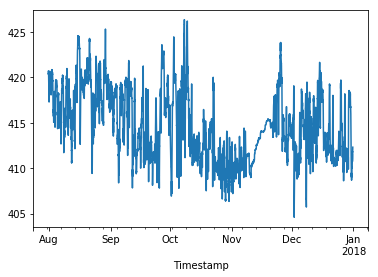

In [36]:
y_pred.plot()

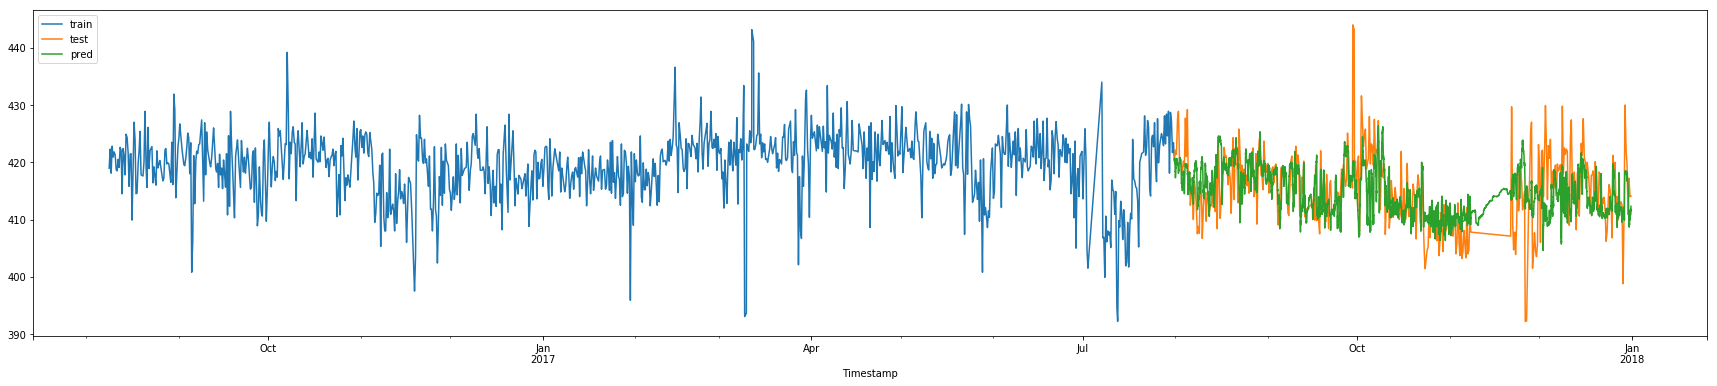

In [37]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')